## Project Outline
##### Our dataset contains CS-related wikipedia articles with their content summarized into text-embeddings. These articles are already categorized into different topics of Computer Science (CS-Subtopics)

### We first create a model to predict an article's correct CS-Subtopic, given the content text embedding as an input.

### We use GNN explainer to get the most important articles (from all subtopics) and see their connections. The connections are how similar each article's content(text-embeddings) are to one another. We can color-code each node with their respective subtopic and see how the subtopics look in relation to the connections. I.e. are most nodes(articles) of the same color (subtopic) mostly connected? And are there some nodes that are connected to many other nodes with different colors(subtopics)?


## Install PyTorch

In [1]:
import torch
import torch_geometric
print("Torch geometric version: ", torch_geometric.__version__)
torch_version = torch.__version__
print("Torch version: ", torch_version)
pytorch_version = f"torch-{torch.__version__}.html"
print("Done.")

/home/datares/.conda/envs/group3_downdate_3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch geometric version:  2.1.0
Torch version:  1.12.1
Done.


## Import WikiCS Dataset

In [2]:
from torch_geometric.datasets import WikiCS
# Dataset source: https://github.com/pmernyei/wiki-cs-dataset
graph = WikiCS(root=".")[0]
graph

/home/datares/.conda/envs/group3_downdate_3/lib/python3.9/site-packages/torch_geometric/datasets/wikics.py:38: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behaviour.
  warnings.warn(


Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])

<Axes: ylabel='Frequency'>

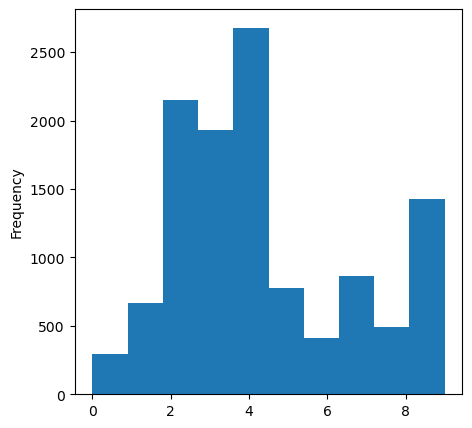

In [3]:
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
df = pd.DataFrame(graph.y.numpy(), columns=["CS_Topics"])
df['CS_Topics'].plot(kind='hist')

## Topic Classification Model (Can we predict the CS-topic based on the article's content)

When passing through GCN and Linear layer we reduce tensor sizes to lessen processing load

In [4]:
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GATConv
embedding_size = 1024

class GNN(torch.nn.Module):
    def __init__(in_graph):
        # Init parent
        super(GNN, in_graph).__init__()

        # GCN layers
        in_graph.initial_conv = GATConv(graph.num_features, embedding_size)
        in_graph.conv1 = GATConv(embedding_size, embedding_size)

        # Output layer
        in_graph.fc = Linear(embedding_size, 10)
        in_graph.out = torch.nn.Softmax()
        # in_graph.explainer_config = ('model',
        #     'attributes',
        #     'object')
        # in_graph.model_config = ('classification',
        #     'node',
        #     'log_probs'  # Model returns log probabilities.
        # )

    def forward(in_graph, x, edge_index):
        emb = F.relu(in_graph.initial_conv(x, edge_index))
        emb = F.relu(in_graph.conv1(emb, edge_index))

        return in_graph.out(in_graph.fc(emb))
    

model = GNN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (initial_conv): GATConv(300, 1024, heads=1)
  (conv1): GATConv(1024, 1024, heads=1)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (out): Softmax(dim=None)
)
Number of parameters:  1372170


## Model Training

In [6]:
# Use GPU for training
from model import GCN, GAT
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GCN()
model = model.to(device)
graph = graph.to(device)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  


def train(train_mask, model):
      model.train()
      optimizer.zero_grad() 
      out = model.forward(graph.x, graph.edge_index)  
      preds = out[train_mask]
      targets = graph.y[train_mask]
      loss = loss_fn(preds, targets)  
      loss.backward() 
      optimizer.step()
      return loss

def test(test_mask, model):
      model.eval()
      optimizer.zero_grad() 
      out = model(graph.x, graph.edge_index)  
      preds = out[test_mask]
      targets = graph.y[test_mask]
      loss = loss_fn(preds, targets)  
      return loss



for epoch in range(0, 800):
    tr_loss = train(graph.train_mask[:,0], model)
    if epoch % 100 == 0:
      loss = test(graph.val_mask[:,0], model)
      print(f'Epoch: {epoch:03d}, Val loss: {loss:.4f} | Train loss: {tr_loss:.4f}')


/home/datares/Group3/model.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return in_graph.out(in_graph.fc(emb))


Epoch: 000, Val loss: 2.3023 | Train loss: 2.3032
Epoch: 100, Val loss: 1.9952 | Train loss: 1.9932
Epoch: 200, Val loss: 1.9472 | Train loss: 1.9365
Epoch: 300, Val loss: 1.8799 | Train loss: 1.8700
Epoch: 400, Val loss: 1.8455 | Train loss: 1.8271
Epoch: 500, Val loss: 1.8400 | Train loss: 1.8170
Epoch: 600, Val loss: 1.8377 | Train loss: 1.8100
Epoch: 700, Val loss: 1.8370 | Train loss: 1.8048


In [7]:
preds = model.forward(graph.x, graph.edge_index)
import torchmetrics
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10, top_k=1).to(device)
print("accuracy = ", accuracy(preds[graph.test_mask], graph.y.to(device)[graph.test_mask]))

accuracy =  tensor(0.6133, device='cuda:0')


## Explaining the Predictions (Only here do we use GNNExplainer)

(links: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html
https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html#torch_geometric.explain.Explainer)

In [9]:
from torch_geometric.nn import GNNExplainer
# Initialize explainer
explainer = GNNExplainer(model, epochs=200, return_type='prob')

# Explain node
node_idx = 69
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph.x, graph.edge_index)
print("Size of explanation: ", sum(edge_mask > 0))

Explain node 69: 100%|██████████| 200/200 [00:12<00:00, 16.51it/s]


Size of explanation:  tensor(274877, device='cuda:0')


In [10]:
# Show shape of masks
print(node_feat_mask.shape)
print(edge_mask.shape)

torch.Size([300])
torch.Size([431726])


In [20]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Visualize result
ax, G = explainer.visualize_subgraph(node_idx, graph.edge_index, edge_mask, y=graph.y)
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

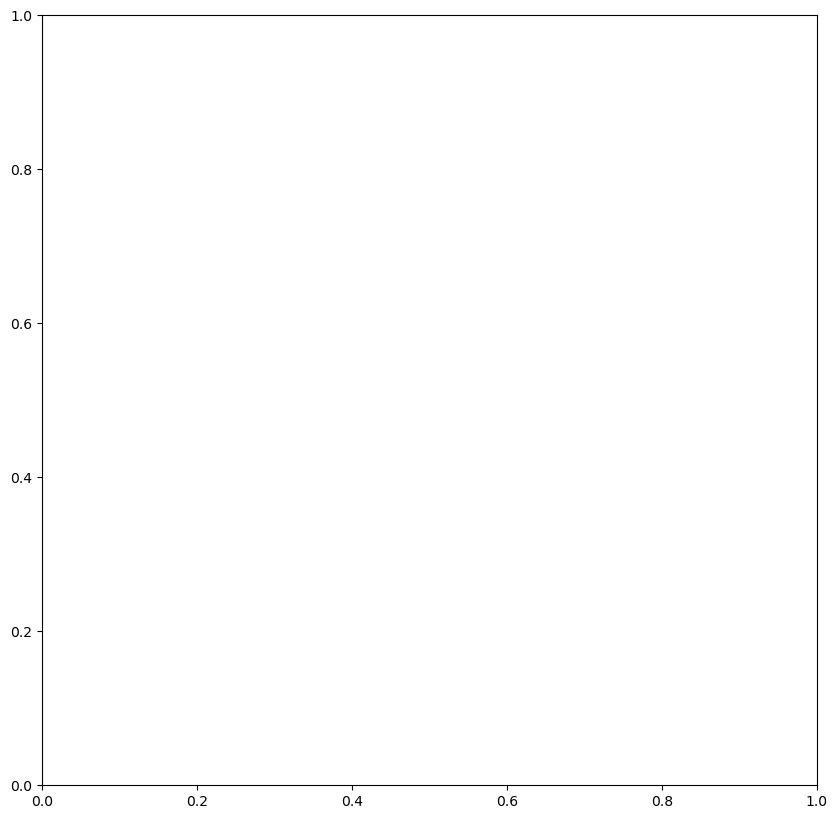

In [27]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
# Visualize result

ax, G = _visualize_graph_via_networkx(edge_index, edge_mask)
plt.show()

In [ ]:
graph.train_mask.shape

In [ ]:
graph.val_mask.shape

## Visualizations